In [1]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cpu


# Make datasets

In [ ]:
audio_files   = './data/BALLROOM/valid_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/valid/'

dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)

idxs = np.random.permutation(len(dataset))[:10]
dataset = beatfinder.datasets.SubAudioBeatsDataset(dataset, idxs)

dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [ ]:
audio_files   = './data/BALLROOM/train_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/train/normal'

dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)

idxs = np.random.permutation(len(dataset))[:10]
dataset = beatfinder.datasets.SubAudioBeatsDataset(dataset, idxs)

dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [ ]:
audio_files   = './data/BALLROOM/train_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/train/augmented'

dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)

idxs = np.random.permutation(len(dataset))[:10]
dataset = beatfinder.datasets.SubAudioBeatsDataset(dataset, idxs)

dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Load train and valid datasets

In [2]:
normal_trainset = beatfinder.datasets.AudioBeatsDataset(
    file='./data/saved-datasets/ballroom/train/normal/dataset.ab')
augmented_trainset = beatfinder.datasets.AudioBeatsDataset(
    file='./data/saved-datasets/ballroom/train/augmented/dataset.ab')
validset = beatfinder.datasets.AudioBeatsDataset(
    file='./data/saved-datasets/ballroom/valid/dataset.ab')

In [3]:
trainset = normal_trainset + augmented_trainset

# Check examples

15/20
Stretch: 0.7341
 Offset: 0.0577


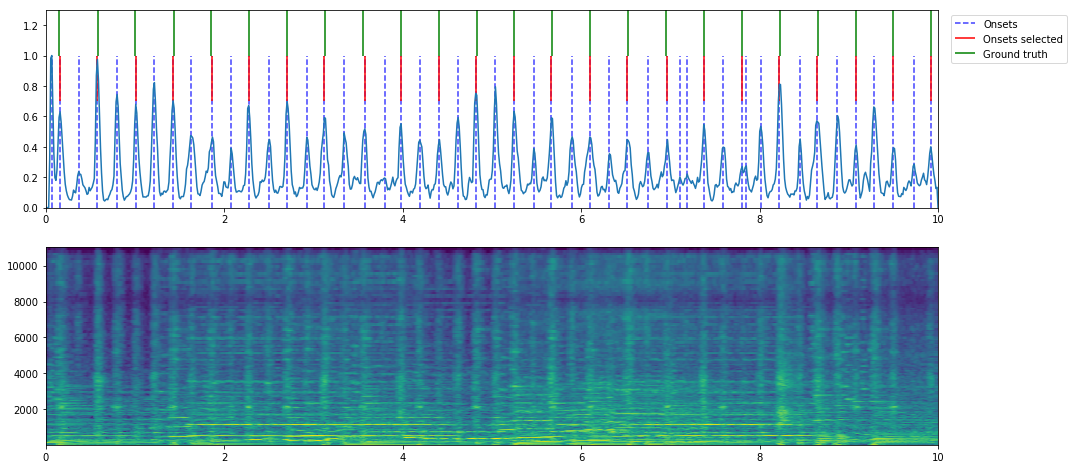

In [14]:
i = np.random.randint(len(trainset))
print(f'{i}/{len(trainset)}')
audiobeats = trainset[i]
print(f'Stretch: {audiobeats.stretch:.4f}')
print(f' Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

F measure: 1.00


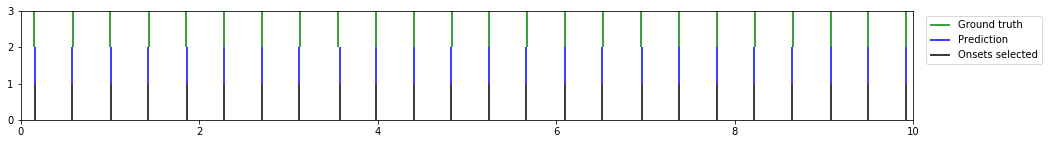

In [15]:
spec, onsets, isbeat, beats = audiobeats.get_data()
onsets_selected = beatfinder.utils.onsets_selected(onsets, isbeat)
pred_beats, bpm = beatfinder.utils.beat_track(onsets_selected)
beatfinder.display.showprediction(beats, pred_beats, onsets_selected)
print(f'F measure: {beatfinder.utils.F_measure(beats, pred_beats):.2f}')

# Setup datasets for pytorch

In [16]:
totensor = beatfinder.model.ToTensor(device)
trainset.transform = totensor
validset.transform = totensor

# Find learning rate

In [17]:
model = beatfinder.model.BeatFinder()
model.to(device)

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

In [18]:
dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

5 mini batches


In [20]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}')

1/5
2/5
3/5
4/5
5/5


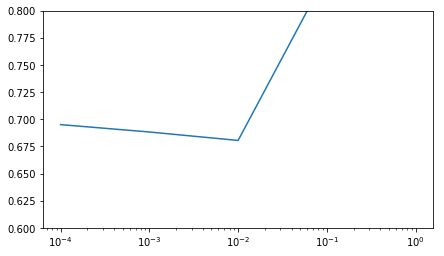

In [21]:
plt.figure(figsize=(7, 4))
plt.ylim(0.6, 0.8)
plt.semilogx(lr, losses);

# Train

In [22]:
model = beatfinder.model.BeatFinder()
model.to(device)
model.set_lr(0.0005)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [23]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:   0 | fp:   0 |
| fn: 169 | tn: 533 |
 -------------------
 Accuracy: 0.7593
Precision: nan
   Recall: nan
F-measure: nan
     Loss: 0.6816


In [24]:
model.unfreeze()
model.train();

In [25]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=4, epochs=2)

| 1 | TL: 0.668 | VL: 0.566 | TF: nan | VF: 0.012 | TA: 0.620 | VA: 0.761 | 7.66 s/b | 0:00:38 | ETA: 0:00:38 |
| 2 | TL: 0.643 | VL: 0.578 | TF: 0.077 | VF: 0.170 | TA: 0.633 | VA: 0.749 | 7.59 s/b | 0:00:37 | ETA: 0:00:00 |


In [ ]:
# torch.save(model.state_dict(), './data/model_09.pt')

In [ ]:
model.eval()
model.freeze()

In [ ]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.legend();

In [ ]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

# Import saved model

In [ ]:
# model = beatfinder.model.BeatFinder()
# model.load_state_dict(torch.load('./data/pretrained-models/model_07.pt', map_location=device))
# model.eval()
# model.freeze()

# Look at an example of a prediction

In [ ]:
dataset = trainset
dataset.transform = None

In [ ]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
beatfinder.display.showdata(audiobeats)

In [ ]:
onsets_selected, beats_pred, bpm = beatfinder.utils.predict_beats(model, audiobeats, totensor)
beats = audiobeats.get_beats()
beatfinder.display.showprediction(beats, beats_pred, onsets_selected)
F = beatfinder.utils.F_measure(beats, beats_pred)
if F != None:
    print(f'F measure: {F:.2f}')
else:
    print('F measure: NaN')

# Evaluate a dataset

In [ ]:
F, F_nan = beatfinder.utils.F_measure_from_dataset(model, dataset, totensor)
print()
print(f'F measure: {F:.2f}')
print(f'     NaNs: {F_nan}')